In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import sys
import os
# import warnings
# warnings.filterwarnings('ignore')

#user = 'madams01'
#sys.path.append(f'/home/{user}/git_clones/copymltox/ml-tox/src')
sys.path.append("/home/ishah/ipynb/ml-tox/src")
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
#from mltox.db.graph_utils import *

import functools
import seaborn as sns

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES']=''
!CUDA_VISIBLE_DEVICES='0'
!export CUDA_VISIBLE_DEVICES
os.getenv('CUDA_VISIBLE_DEVICES')


# Data

## EDKB

In [20]:
D='/home/ishah/ipynb/ml-tox/data/edkb/'
!ls $D

EDKB.csv  EKDB-CCD-Batch-Search_2024-02-06_08_57_22.csv


In [36]:
EDKB = pd.read_csv(D+'EDKB.csv')
X = pd.read_csv(D+'EKDB-CCD-Batch-Search_2024-02-06_08_57_22.csv')[['INPUT','DTXSID','SMILES']]
X.columns=X.columns.str.lower()
X.rename(columns=dict(input='Name'),inplace=True)
EDKB1 = EDKB.merge(X,on='Name',how='right').drop_duplicates()
EDKB1.AssayName.value_counts()

AssayName
Uterotrophic Assay                          1249
ER Binding (Receptor Binding Assay)          595
ER Gene (Reporter Gene Assay)                558
AR Binding (Receptor Binding Assay)          236
Escreen (Cell Proliferation Assay)           143
Proliferation (Cell Proliferation Assay)      19
Name: count, dtype: int64

## ATG

In [37]:
DAT='/home/ishah/ipynb/ml-tox/data/bio/'
CH_ATG = pd.read_csv(DAT+'chm-atg.csv')
CH_ATG

,dsstox_sid,smiles,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,DTXSID0020232,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,DTXSID0020236,[Ca++].CC(O)C([O-])=O.CC(O)C([O-])=O,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,DTXSID0020280,[O-][N+](=O)C1=C(Cl)C=CC=C1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,DTXSID0020282,NC1=CC(N)=C(Cl)C=C1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID0020284,OS(O)(=O)=O.NC1=CC=C(N)C(Cl)=C1,1,0,1,1,0,0,1,1,...,1,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,DTXSID9051907,COC1=NC=CN=C1CC(C)C,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3475,DTXSID9052505,CCCCC(C)=C,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3476,DTXSID9052509,OC1=CC=C(C=C1)C#N,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3477,DTXSID9052846,COCC(C)N(C(=O)CS(O)(=O)=O)C1=CSC=C1C,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## ER


In [5]:
ER0 = pd.read_excel(DAT+'ER plus minus.xlsx')
ER0.columns=ER0.columns.str.replace('.','_').str.lower()
#ER0.loc[:,'er_class']=ER0.er_class.apply(lambda i: int(i)).astype(np.uint)

In [6]:
ER0.head()

,dtxsid,casrn,name,refchem_agonist,refchem_antagonist,auc_agonist,er_class
0,DTXSID8022377,57-91-0,17alpha-Estradiol,moderate,NaN,1.060,1.0
1,DTXSID5020576,57-63-6,17alpha-Ethinylestradiol,strong,inactive,1.000,1.0
2,DTXSID2022381,84-16-2,meso-Hexestrol,strong,NaN,0.993,1.0
3,DTXSID3020465,56-53-1,Diethylstilbestrol,strong,inactive,0.943,1.0
4,DTXSID0020573,50-28-2,17beta-Estradiol,NaN,NaN,0.935,1.0


In [7]:
ER0.er_class.value_counts()

er_class
0.0    1537
0.5     177
1.0      93
Name: count, dtype: int64

In [8]:
SID1 = set(ER0.dtxsid).intersection(CH_ATG.dsstox_sid)
ER0.shape[0],CH_ATG.shape[0],len(SID1)

(1807, 3479, 1699)

In [42]:
EDKB1.AssayName.value_counts()-EDKB1[EDKB1.dtxsid.isin(CH_ATG.dsstox_sid)].AssayName.value_counts()

AssayName
AR Binding (Receptor Binding Assay)          150
ER Binding (Receptor Binding Assay)          419
ER Gene (Reporter Gene Assay)                311
Escreen (Cell Proliferation Assay)            85
Proliferation (Cell Proliferation Assay)      13
Uterotrophic Assay                          1169
Name: count, dtype: int64

# Features

In [9]:
DB5 = openMongo(db='genra_dev_v5',host='localhost',auth=False)
CH0 = pd.DataFrame(DB5.compounds.find(dict(dsstox_sid={'$in':ER0.dtxsid.tolist()}),
                                      dict(_id=0,dsstox_sid=1,smiles=1)))\
        .rename(columns=dict(dsstox_sid='dtxsid'))
ER1 = ER0.merge(CH0,on='dtxsid').drop_duplicates()
CH0.shape[0],ER0.shape[0],ER1.shape[0]


(1806, 1807, 1807)

In [76]:
ER1.sample(10)

,dtxsid,casrn,name,refchem_agonist,refchem_antagonist,auc_agonist,er_class,smiles
1790,DTXSID7027837,24800-44-0,Tripropylene glycol,NaN,NaN,0.00000,0.0,"C*.C*.C*.OCCOCCOCCO |lp:6:2,9:2,12:2,15:2,m:1:..."
1370,DTXSID1034929,283594-90-1,Spiromesifen,NaN,NaN,0.00000,0.0,CC1=CC(C)=C(C2=C(OC(=O)CC(C)(C)C)C3(CCCC3)OC2=...
1362,DTXSID4024193,94-81-5,MCPB,NaN,NaN,0.00000,0.0,CC1=C(OCCCC(O)=O)C=CC(Cl)=C1
318,DTXSID4034150,52-86-8,Haloperidol,inactive,NaN,0.00598,0.0,OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...
781,DTXSID2021864,105-67-9,"2,4-Dimethylphenol",NaN,NaN,0.00000,0.0,CC1=CC(C)=C(O)C=C1
319,DTXSID2021993,132-64-9,Dibenzofuran,NaN,NaN,0.00597,0.0,O1C2=CC=CC=C2C2=C1C=CC=C2
1099,DTXSID7021106,87-86-5,Pentachlorophenol,NaN,NaN,0.00000,0.0,OC1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1Cl
830,DTXSID6032514,643-79-8,"1,2-Benzenedicarboxaldehyde",NaN,NaN,0.00000,0.0,O=CC1=CC=CC=C1C=O
889,DTXSID5020281,100-00-5,1-Chloro-4-nitrobenzene,NaN,NaN,0.00000,0.0,[O-][N+](=O)C1=CC=C(Cl)C=C1
747,DTXSID2021575,75-99-0,Dalapon,NaN,NaN,0.00000,0.0,CC(Cl)(Cl)C(O)=O


In [151]:
# CH1 = pd.read_csv('/home/ishah/ipynb/ml-tox/data/chm/CCD-Batch-Search_2024-01-05_10_40_53.csv')
# CH1.columns=CH1.columns.str.lower()
# CH1 = CH1[['dtxsid','smiles']].dropna()
# ER2 = ER0.merge(CH1,on='dtxsid')
# CH1.shape,ER0.shape,ER2.shape

In [ ]:
ER1.sample(10)

In [43]:
import deepchem as dc
from deepchem.models.torch_models import AttentiveFPModel
#import scipy


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-06 17:56:46.991318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:56:46.991570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:56:47.358104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 17:5

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [152]:
import deepchem as dc
from deepchem.models import AttentiveFPModel
import scipy

DS_er = dc.data.NumpyDataset(ER1.smiles,ER1.er_class)
FT = dc.trans.FeaturizationTransformer(DS_er, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_er = FT.transform(DS_er)

Failed to featurize datapoint 19, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 152, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 161, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 287, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 291, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 300, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 417, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 433, None. Appending empty array
Exception message: 'N

In [153]:
#[i for i in DS.X if i.num]
#[type(i) for i in list(DS.X)]
Keep_er=[]
for i,v in enumerate(DS_er.X):
    #print(i.num_nodes)
    try:
        n = v.num_nodes
    except:
        print(i,CH_ATG.dsstox_sid[i])
    else:
        Keep_er.append(i)

19 DTXSID0020575
152 DTXSID0032314
161 DTXSID0032651
287 DTXSID0047375
291 DTXSID0047406
300 DTXSID0047585
417 DTXSID1022265
433 DTXSID1024049
461 DTXSID1025433
497 DTXSID1027390
501 DTXSID1027502
514 DTXSID1029128
515 DTXSID1029170
556 DTXSID1034973
630 DTXSID1044697
660 DTXSID1047312
735 DTXSID2020927
749 DTXSID2021288
773 DTXSID2021995
820 DTXSID2025216
875 DTXSID2029298
963 DTXSID2044470
980 DTXSID2044892
1067 DTXSID3020916
1112 DTXSID3022405
1127 DTXSID3023974
1151 DTXSID3025047
1190 DTXSID3027584
1206 DTXSID3031492
1221 DTXSID3032622
1245 DTXSID3036525
1246 DTXSID3037094
1254 DTXSID3038800
1383 DTXSID4020290
1387 DTXSID4020371
1390 DTXSID4020379
1422 DTXSID4021347
1425 DTXSID4021426
1432 DTXSID4021717
1435 DTXSID4021848
1489 DTXSID4024729
1490 DTXSID4024775
1491 DTXSID4024931
1492 DTXSID4024937
1519 DTXSID4027072
1525 DTXSID4027282
1526 DTXSID4027284
1557 DTXSID4032459
1563 DTXSID4032619
1565 DTXSID4034150
1566 DTXSID4034287
1579 DTXSID4036229
1593 DTXSID4040002
1610 DTXSID404136

In [154]:
DS_er  = DS_er.select(Keep_er)
len(Keep)


3469

In [108]:
Y_names = CH_ATG.columns[2:]
DS = dc.data.NumpyDataset(CH_ATG.smiles,CH_ATG.iloc[:,2:])
FT = dc.trans.FeaturizationTransformer(DS, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS = FT.transform(DS)

Failed to featurize datapoint 244, [Br-].[Br-].[Ca+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 272, [Cl-].[Cl-].[Cl-].[Yb+3]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 913, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 932, [I-].[Na+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1505, [Cl-].[Cl-].[Pd+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1769, [Cl-].[Cl-].[Hg+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1979, [Cu+].[I-]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 2669, [Cl-].[Cl-].[Ni+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3040, [C

In [109]:
#[i for i in DS.X if i.num]
#[type(i) for i in list(DS.X)]
Keep=[]
for i,v in enumerate(DS.X):
    #print(i.num_nodes)
    try:
        n = v.num_nodes
    except:
        print(i,CH_ATG.dsstox_sid[i])
    else:
        Keep.append(i)

DS  = DS.select(Keep)

244 DTXSID0044577
272 DTXSID0047117
913 DTXSID2035013
932 DTXSID2041125
1505 DTXSID4025824
1769 DTXSID5020811
1979 DTXSID5041803
2669 DTXSID7040316
3040 DTXSID8041909
3341 DTXSID9036933


In [110]:
AFP_full = AttentiveFPModel(mode='classification',                             
                            n_tasks=DS.y.shape[1],
                            num_layers=2,
                            graph_feat_size=100,
                            batch_size=16, 
                            learning_rate=0.001)
AFP_full.fit(DS,nb_epoch=40)


0.34054491519927976

In [155]:
ER_pred_0 = AFP_full.predict(DS_er)

In [156]:
Y_names.get_loc('ATG_ERa_TRANS')

16

In [157]:
ER_pred = pd.DataFrame(dict(dtxsid=ER1.iloc[Keep_er].dtxsid,er_pred=ER_pred_0[:,16,1]))
                      
ER_pred

,dtxsid,er_pred
0,DTXSID8022377,0.664560
1,DTXSID5020576,0.345774
2,DTXSID2022381,0.868559
3,DTXSID3020465,0.883496
4,DTXSID0020573,0.664560
...,...,...
1802,DTXSID1024255,0.187101
1803,DTXSID7047304,0.380105
1804,DTXSID3047267,0.066176
1805,DTXSID4032615,0.040392


# Questions from Richard

For the ATG data, what is prediction concordance for the 1 and 0 class?

In [163]:
#SID1 = set(ER0.dtxsid).intersection(CH_ATG.dsstox_sid)
#ER0.shape[0],CH_ATG.shape[0],len(SID1)
from sklearn.metrics import cohen_kappa_score

X = ER0.merge(CH_ATG.rename(columns=dict(dsstox_sid='dtxsid')))\
        .query("er_class!=0.5")


agree_ATG  = sum(a==b for a,b in zip(X.er_class,X.ATG_ERa_TRANS))/X.shape[0]

kappa_ATG  = cohen_kappa_score(X.er_class,X.ATG_ERa_TRANS)

agree_ATG,kappa_ATG


(0.6749509483322433, 0.16950397317627885)

For the ATG predictions, what is the prediction concordance to the 1 and 0 data?
Is the concordance better for the predictions than for the data?

In [164]:
X1 = ER0.merge(ER_pred,on='dtxsid').query("er_class!=0.5")


In [167]:
Res = []
for p0 in [0.5, 0.6, 0.7, 0.8, 0.9]:
    Yi = X1.er_pred.apply(lambda i: 1 if i>=p0 else 0)
    agree  = sum(a==b for a,b in zip(X1.er_class,Yi))/X.shape[0]
    kappa = cohen_kappa_score(X1.er_class,Yi)
    Res.append(dict(p0=p0,agree=agree,n_pos=Yi.sum(),n_neg=Yi.shape[0]-Yi.sum(),kappa=kappa))

pd.DataFrame(Res)

,p0,agree,n_pos,n_neg,kappa
0,0.5,0.722695,530,1039,0.171200
1,0.6,0.793329,408,1161,0.212656
2,0.7,0.855461,285,1284,0.240346
3,0.8,0.914323,161,1408,0.269603
4,0.9,0.956835,54,1515,0.241054


What are the predictions for the 0.5 class?

<Axes: >

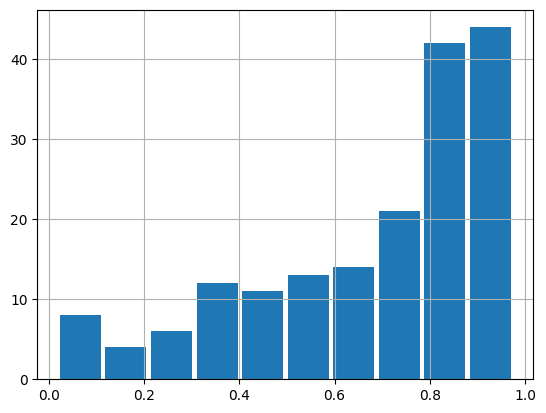

In [174]:
X2 = ER0.merge(ER_pred,on='dtxsid')

X2[X2.er_class==0.5].er_pred.hist(rwidth=0.9)

In [118]:
X.columns[X.columns.str.contains('_ER')]

Index(['ATG_ERE_CIS', 'ATG_ERRa_TRANS', 'ATG_ERRg_TRANS', 'ATG_ERa_TRANS'], dtype='object')

In [177]:
X2 = ER0.merge(ER_pred,on='dtxsid')\
        .merge(CH_ATG[['dsstox_sid','ATG_ERa_TRANS']].rename(columns=dict(dsstox_sid='dtxsid')),on='dtxsid')\
        .rename(columns=dict(er_pred='afp_atg_er_pred'))

In [178]:
X2

,dtxsid,casrn,name,refchem_agonist,refchem_antagonist,auc_agonist,er_class,afp_atg_er_pred,ATG_ERa_TRANS
0,DTXSID8022377,57-91-0,17alpha-Estradiol,moderate,NaN,1.060,1.0,0.664560,0
1,DTXSID5020576,57-63-6,17alpha-Ethinylestradiol,strong,inactive,1.000,1.0,0.345774,0
2,DTXSID2022381,84-16-2,meso-Hexestrol,strong,NaN,0.993,1.0,0.868559,1
3,DTXSID3020465,56-53-1,Diethylstilbestrol,strong,inactive,0.943,1.0,0.883496,1
4,DTXSID0020573,50-28-2,17beta-Estradiol,NaN,NaN,0.935,1.0,0.664560,1
...,...,...,...,...,...,...,...,...,...
1693,DTXSID1024255,13684-63-4,Phenmedipham,NaN,NaN,0.000,0.0,0.187101,0
1694,DTXSID7047304,135080-03-4,CP-100829,NaN,NaN,0.000,0.0,0.380105,1
1695,DTXSID3047267,NOCAS_47267,CP-642931,NaN,NaN,0.000,0.0,0.066176,0
1696,DTXSID4032615,98967-40-9,Flumetsulam,NaN,NaN,0.000,0.0,0.040392,0


In [180]:
X2.to_excel("/home/ishah/Documents/ER-AFP-ATG-preds-01-05-24.xlsx")

# RefChem

In [191]:
#DB5.toxcast_assays.find_one(dict(assay_source_name='LTEA'))

In [225]:
Assays = pd.DataFrame(DB5.toxcast_assays.find(dict(assay_component_name={'$in':Y_names.tolist()}),
                                              dict(_id=0,assay_component_name=1,official_symbol=1)))\
            .drop_duplicates()\
            .query("official_symbol!='NA'")\
            .rename(columns=dict(assay_component_name='assay',
                                 official_symbol='gene'))
Assays                                                   


,assay,gene
0,ATG_Ahr_CIS,AHR
2,ATG_AP_1_CIS,JUN
4,ATG_AP_2_CIS,TFAP2D
6,ATG_BRE_CIS,SMAD1
8,ATG_C_EBP_CIS,CEBPB
...,...,...
150,ATG_RORg_TRANS,RORC
152,ATG_RXRa_TRANS,RXRA
154,ATG_RXRb_TRANS,RXRB
156,ATG_THRa1_TRANS,THRA


In [182]:
RC0 = pd.read_excel("~/ipynb/bio-kb/data/inputs/refchem/RefChemDB_from Judson et al 2019.xlsx")

In [184]:
RC0.head()

,dsstox_substance_id,casrn,name,target,target_type,mode,activity_class,support,in_cmap
0,DTXSID7022544,59-66-5,Acetazolamide,CA2,gene,Negative,active,286,0
1,DTXSID7022544,59-66-5,Acetazolamide,CA1,gene,Negative,active,276,0
2,DTXSID0020573,50-28-2,17beta-Estradiol,ESR1,gene,unspecified,active,206,1
3,DTXSID6041133,149647-78-9,Suberoylanilide hydroxamic acid,HDAC1,gene,Negative,active,206,0
4,DTXSID7022544,59-66-5,Acetazolamide,CA9,gene,Negative,active,181,0


<Axes: >

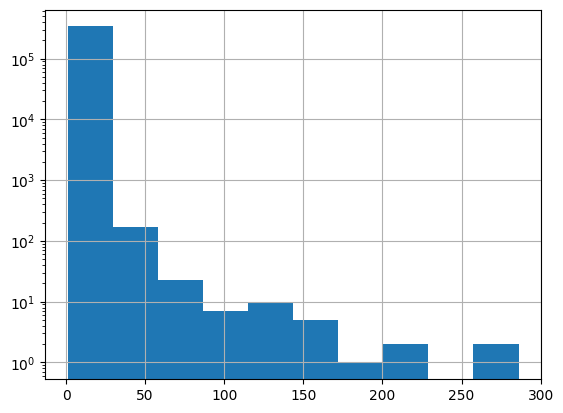

In [202]:
RC0.support.hist(log=True)

In [213]:
RC1 = RC0[RC0.target.isin(Assays.official_symbol)]\
        .rename(columns=dict(dsstox_substance_id='dtxsid',
                             target='gene',
                             activity_class='activity'))[['dtxsid','gene','activity','support']]
                

In [208]:
#RC1[RC1.target=='PPARA']

In [214]:
CH2 = pd.DataFrame(DB5.compounds.find(dict(dsstox_sid={'$in':RC1.dtxsid.tolist()}),
                                      dict(_id=0,dsstox_sid=1,smiles=1)))\
        .rename(columns=dict(dsstox_sid='dtxsid'))


In [231]:
RC2 = RC1.merge(CH2,on='dtxsid')\
         .replace(dict(activity=dict(active=1)))

/tmp/ipykernel_421315/3384079504.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(dict(activity=dict(active=1)))


In [232]:
RC2.head()

,dtxsid,gene,activity,support,smiles
0,DTXSID0020573,ESR1,1,206,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@]1([H])C3=CC...
1,DTXSID0020573,ESR1,1,142,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@]1([H])C3=CC...
2,DTXSID4020290,PPARA,1,115,CC1=C(C)C(NC2=NC(SCC(O)=O)=NC(Cl)=C2)=CC=C1
3,DTXSID7037131,PPARG,1,113,CN(CCOC1=CC=C(CC2SC(=O)NC2=O)C=C1)C1=NC=CC=C1
4,DTXSID9022364,AR,1,82,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@...


In [218]:
import deepchem as dc
from deepchem.models import AttentiveFPModel
import scipy

DS_rc = dc.data.NumpyDataset(CH2.smiles)
FT = dc.trans.FeaturizationTransformer(CH2, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_rc = FT.transform(DS_rc)

Failed to featurize datapoint 0, O.O.O.O.O.O.[Cl-].[Cl-].[Sr+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 75, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 362, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 762, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 912, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 1279, None. Appending empty array
Exception message: 'NoneType' object has no attribute 'GetNumAtoms'
Failed to featurize datapoint 1296, [Hg]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 1373, None. Appendi

In [219]:
#[i for i in DS.X if i.num]
#[type(i) for i in list(DS.X)]
Keep_rc=[]
for i,v in enumerate(DS_rc.X):
    #print(i.num_nodes)
    try:
        n = v.num_nodes
    except:
        print(i,CH2.dtxsid[i])
    else:
        Keep_rc.append(i)

0 DTXSID00143067
75 DTXSID0020101
362 DTXSID0027933
762 DTXSID0041721
912 DTXSID0047242
1279 DTXSID1023780
1296 DTXSID1024172
1373 DTXSID1027394
1784 DTXSID1040821
1788 DTXSID1041059
2625 DTXSID2035013
2813 DTXSID2040230
3938 DTXSID3040223
3942 DTXSID3040516
3958 DTXSID3040803
4070 DTXSID3045354
4244 DTXSID3093945
4533 DTXSID4023884
4569 DTXSID4024983
4693 DTXSID4029648
5299 DTXSID40859317
5387 DTXSID5020100
5434 DTXSID5020811
5603 DTXSID5023954
5736 DTXSID5029055
5787 DTXSID5030743
6006 DTXSID5037070
6231 DTXSID5045750
6510 DTXSID6020226
6653 DTXSID60228586
6872 DTXSID6029755
7291 DTXSID6044561
7314 DTXSID6045406
7588 DTXSID7020215
7670 DTXSID7021368
7733 DTXSID7022706
7756 DTXSID7023190
7801 DTXSID7023982
7833 DTXSID7024906
8306 DTXSID7040235
8311 DTXSID7040316
8314 DTXSID7040449
8427 DTXSID7044508
8503 DTXSID7046750
8533 DTXSID7047853
8595 DTXSID7057814
8633 DTXSID80108179
9033 DTXSID8027870
9035 DTXSID8027905
9449 DTXSID8040850
9602 DTXSID8046666
9689 DTXSID8049206
9919 DTXSID90211

In [221]:
DS_rc  = DS_rc.select(Keep_rc)

In [222]:
RC_pred_0 = AFP_full.predict(DS_rc)

In [223]:
Res = []
for i,assay in enumerate(Y_names):
    P_i = pd.DataFrame(dict(assay=assay,
                            dtxsid=CH2.iloc[Keep_rc].dtxsid,
                            pred=RC_pred_0[:,i,1]))
    Res.append(P_i)

In [235]:
RC_pred=pd.concat(Res).merge(Assays,on='assay')\
           .merge(RC2,on=['dtxsid','gene'])\
           .drop('smiles',axis=1)

,assay,dtxsid,pred,gene,activity,support
0,ATG_AP_1_CIS,DTXSID0020650,0.701200,JUN,1,1
1,ATG_AP_1_CIS,DTXSID0023169,0.582668,JUN,1,2
2,ATG_AP_1_CIS,DTXSID0036768,0.671324,JUN,1,1
3,ATG_AP_1_CIS,DTXSID00431335,0.721593,JUN,1,1
4,ATG_AP_1_CIS,DTXSID1021584,0.354799,JUN,1,1
...,...,...,...,...,...,...
40938,ATG_p53_CIS,DTXSID90409326,0.689295,TP53,1,1
40939,ATG_p53_CIS,DTXSID90416575,0.598777,TP53,1,1
40940,ATG_p53_CIS,DTXSID90430534,0.287691,TP53,1,1
40941,ATG_p53_CIS,DTXSID9062772,0.658385,TP53,1,1


## Performance

Calculate the percentage of positive chemicals by RefChem correctly called positive by AFP for different levels of p0 and support

In [245]:
Res = []
s0=3
for (gene, assay),X_i in RC_pred.groupby(['gene','assay']):
    
    for s0 in [3,5,10,20]:
        X_j=X_i[X_i.support>=s0]
        
        for p0 in [0.5,0.6,0.7,0.8,0.9]:
            X_k = X_j[X_j.pred>=p0]
            if X_k.shape[0]==0: continue
            n_pos,n_pred=X_j.shape[0],X_k.shape[0]
            pred_pos = n_pred/n_pos*1.0
            Res.append(dict(gene=gene,assay=assay,p0=p0,s0=s0,accuracy=pred_pos,
                            n_pos=n_pos,n_pred=n_pred))
        
PERF = pd.DataFrame(Res)                      
        


In [248]:
PERF[(PERF.p0==0.5) & (PERF.s0==3)]

,gene,assay,p0,s0,accuracy,n_pos,n_pred
0,AHR,ATG_Ahr_CIS,0.5,3,0.914286,35,32
10,AR,ATG_AR_TRANS,0.5,3,0.016667,120,2
11,ESR1,ATG_ERE_CIS,0.5,3,0.917808,146,134
31,ESR1,ATG_ERa_TRANS,0.5,3,0.780822,146,114
51,HIF1A,ATG_HIF1a_CIS,0.5,3,1.000000,4,4
57,NFE2L2,ATG_NRF2_ARE_CIS,0.5,3,0.857143,7,6
72,NFKB1,ATG_NF_kB_CIS,0.5,3,0.500000,6,3
78,NR1H3,ATG_DR4_LXR_CIS,0.5,3,0.250000,4,1
80,NR1H4,ATG_IR1_CIS,0.5,3,0.687500,16,11
92,NR1I2,ATG_PXRE_CIS,0.5,3,1.000000,28,28


In [271]:
PERF.insert(1,'GeneAssay',PERF.apply(lambda x: x['gene']+': '+x['assay'],axis=1))

/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/categorical.py:1202: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/categorical.py:1202: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/categorical.py:1202: FutureWarning: Da

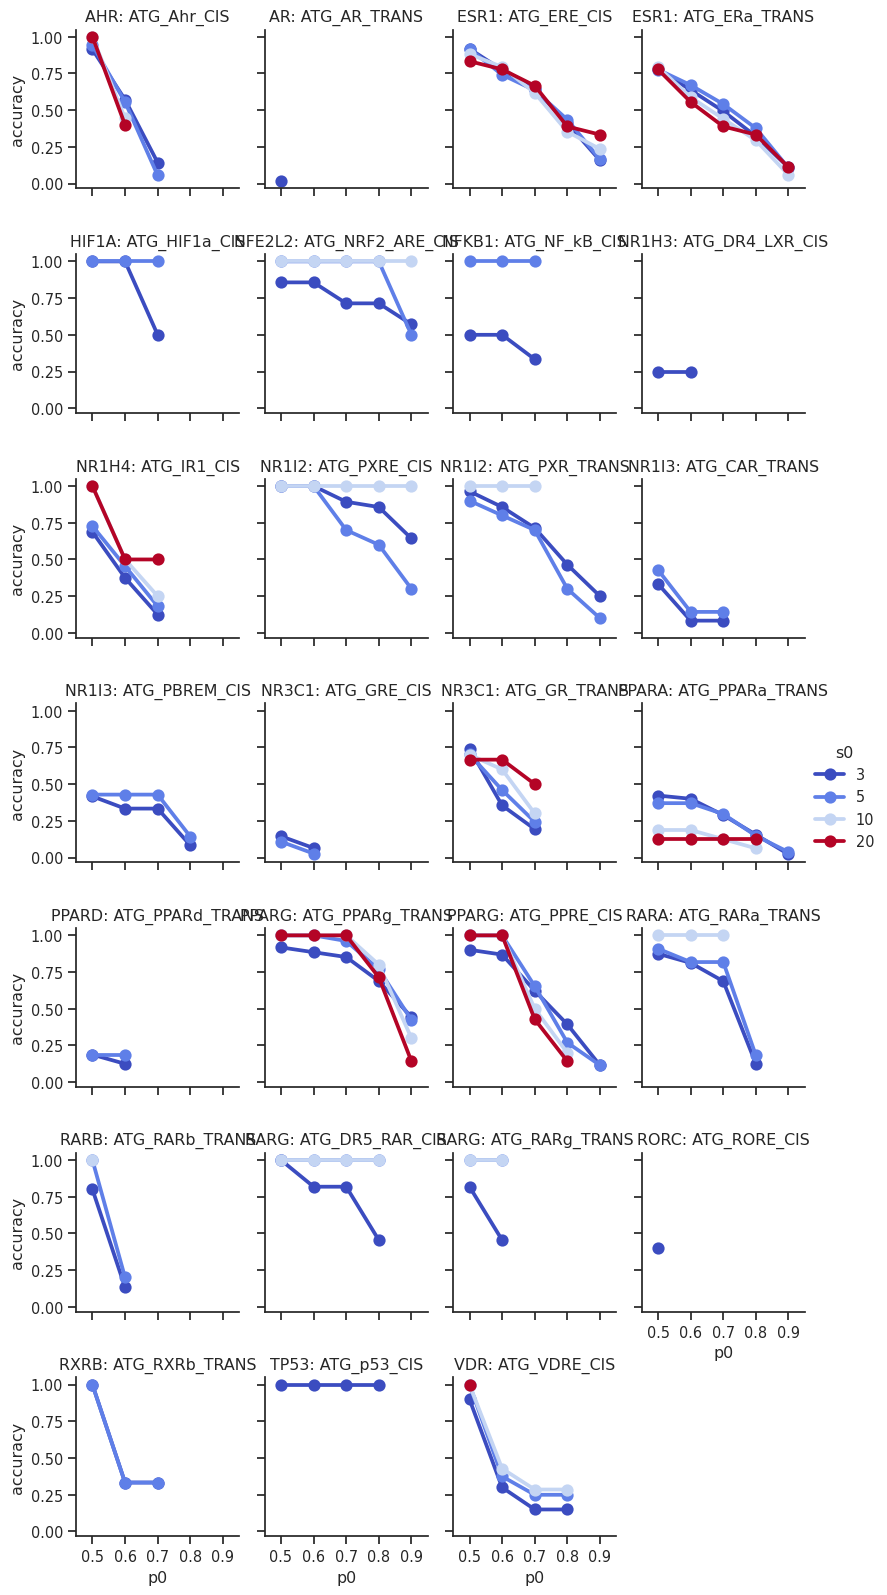

In [272]:
import seaborn as sns
import matplotlib.patches as patches
import pylab as pl 
sns.set(font_scale=0.95,style='ticks')

g = sns.catplot(data=PERF,col='GeneAssay',col_wrap=4,
            x='p0',y='accuracy',hue='s0',
            height=2.3,aspect=0.9,
            palette='coolwarm',
            kind='point')
g.set_titles(row_template='{row_name}',col_template='{col_name}')            

In [253]:
RC_pred1 = RC_pred[~RC_pred.dtxsid.isin(CH_ATG.dsstox_sid)]
RC_pred.shape[0],RC_pred1.shape[0]

(40943, 27774)

In [299]:
len(RC_pred1.dtxsid.unique())

8749

In [259]:
Res = []
s0=3
for (gene, assay),X_i in RC_pred1.groupby(['gene','assay']):
    
    for s0 in [3,5,10,20]:
        X_j=X_i[X_i.support>=s0]
        
        for p0 in [0.5,0.6,0.7,0.8,0.9]:
            X_k = X_j[X_j.pred>=p0]
            if X_k.shape[0]==0: continue
            n_pos,n_pred=X_j.shape[0],X_k.shape[0]
            pred_pos = n_pred/n_pos*1.0
            Res.append(dict(gene=gene,assay=assay,p0=p0,s0=s0,accuracy=pred_pos,
                            n_pos=n_pos,n_pred=n_pred))
        
PERF2 = pd.DataFrame(Res)                      
        


In [298]:
PERF2[(PERF2.p0==0.5) & (PERF2.s0==3)].sort_values('accuracy',ascending=False)

,gene,GeneAssay,assay,p0,s0,accuracy,n_pos,n_pred
0,AHR,AHR: ATG_Ahr_CIS,ATG_Ahr_CIS,0.5,3,1.000000,20,20
70,NR1I2,NR1I2: ATG_PXRE_CIS,ATG_PXRE_CIS,0.5,3,1.000000,7,7
202,TP53,TP53: ATG_p53_CIS,ATG_p53_CIS,0.5,3,1.000000,1,1
38,HIF1A,HIF1A: ATG_HIF1a_CIS,ATG_HIF1a_CIS,0.5,3,1.000000,4,4
200,RXRB,RXRB: ATG_RXRb_TRANS,ATG_RXRb_TRANS,0.5,3,1.000000,2,2
188,RARG,RARG: ATG_DR5_RAR_CIS,ATG_DR5_RAR_CIS,0.5,3,1.000000,6,6
159,PPARG,PPARG: ATG_PPRE_CIS,ATG_PPRE_CIS,0.5,3,0.935484,31,29
139,PPARG,PPARG: ATG_PPARg_TRANS,ATG_PPARg_TRANS,0.5,3,0.935484,31,29
10,ESR1,ESR1: ATG_ERE_CIS,ATG_ERE_CIS,0.5,3,0.924528,53,49
206,VDR,VDR: ATG_VDRE_CIS,ATG_VDRE_CIS,0.5,3,0.875000,16,14


In [261]:
PERF2.insert(1,'GeneAssay',PERF2.apply(lambda x: x['gene']+': '+x['assay'],axis=1))

/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/categorical.py:1202: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/categorical.py:1202: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/categorical.py:1202: FutureWarning: Da

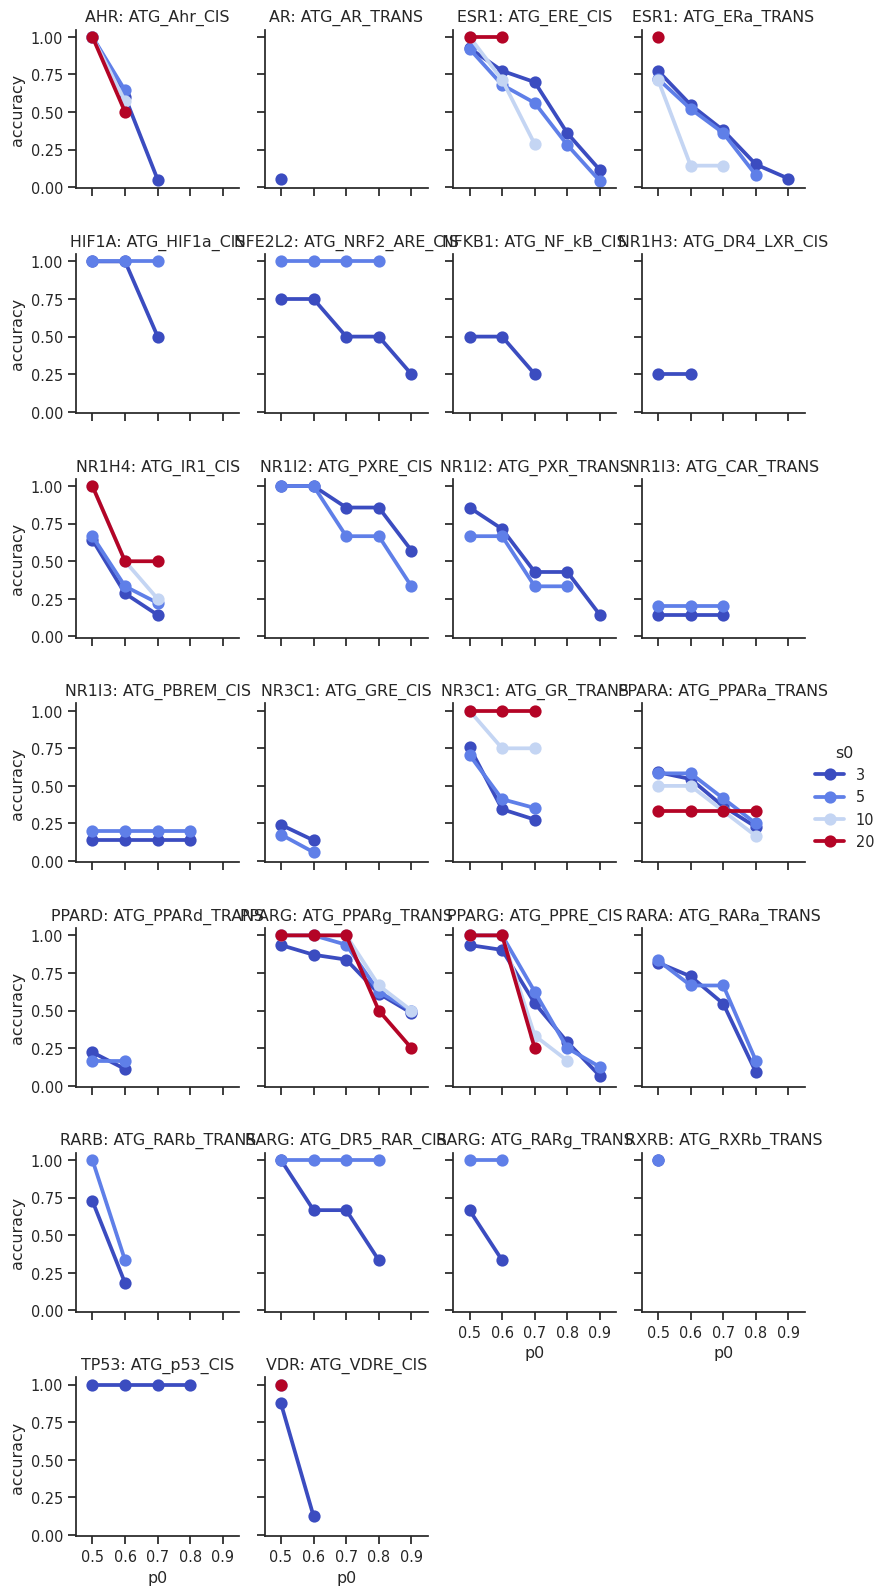

In [269]:
import seaborn as sns
import matplotlib.patches as patches
import pylab as pl 
sns.set(font_scale=0.95,style='ticks')

g = sns.catplot(data=PERF2,col='GeneAssay',col_wrap=4,
            x='p0',y='accuracy',hue='s0',
            height=2.3,aspect=0.9,
            palette='coolwarm',
            kind='point')
g.set_titles(row_template='{row_name}',col_template='{col_name}')            

In [280]:
X = CH_ATG.rename(columns=dict(dsstox_sid='dtxsid'))\
          .drop('smiles',axis=1)\
          .melt(id_vars='dtxsid',var_name='assay',value_name='assay_activity')

RC_pred3 = RC_pred[RC_pred.dtxsid.isin(CH_ATG.dsstox_sid)]\
            .merge(X,on=['dtxsid','assay'])


In [281]:
RC_pred3

,assay,dtxsid,pred,gene,activity,support,assay_activity
0,ATG_AP_1_CIS,DTXSID1022396,0.533029,JUN,1,1,1
1,ATG_AP_1_CIS,DTXSID3029869,0.346596,JUN,1,1,0
2,ATG_AP_1_CIS,DTXSID4020290,0.493751,JUN,1,1,0
3,ATG_AP_1_CIS,DTXSID4020290,0.493751,JUN,1,1,0
4,ATG_AP_1_CIS,DTXSID6022391,0.578365,JUN,1,1,1
...,...,...,...,...,...,...,...
13164,ATG_p53_CIS,DTXSID9032589,0.620142,TP53,1,1,1
13165,ATG_p53_CIS,DTXSID9033923,0.064774,TP53,1,1,0
13166,ATG_p53_CIS,DTXSID9034492,0.637390,TP53,1,1,1
13167,ATG_p53_CIS,DTXSID9037749,0.701651,TP53,1,1,1


In [290]:
Res = []
s0=3
for (gene, assay),X_i in RC_pred3.groupby(['gene','assay']):
    
    for s0 in [3,5,10,20]:
        X_j=X_i[X_i.support>=s0]
        if X_j.shape[0]==0: continue
        n_asy = (X_j.assay_activity==X_j.activity).sum()
        for p0 in [0.5,0.6,0.7,0.8,0.9]:
            X_k = X_j[X_j.pred>=p0]
            if X_k.shape[0]==0: continue
            n_pos,n_pred=X_j.shape[0],X_k.shape[0]
            Res.append(dict(gene=gene,assay=assay,p0=p0,s0=s0,
                            n_pos=n_pos,n_pred=n_pred,n_asy=n_asy,
                            accuracy_ml=n_pred/n_pos*1.0,
                            accuracy_asy=n_asy/n_pos*1.0                            
                            ))
        
PERF3 = pd.DataFrame(Res)                      
        


In [291]:
PERF3[(PERF3.p0==0.5) & (PERF3.s0==3)]

,gene,assay,p0,s0,n_pos,n_pred,n_asy,accuracy_ml,accuracy_asy
0,AHR,ATG_Ahr_CIS,0.5,3,15,12,12,0.800000,0.800000
8,ESR1,ATG_ERE_CIS,0.5,3,93,85,71,0.913978,0.763441
28,ESR1,ATG_ERa_TRANS,0.5,3,93,73,79,0.784946,0.849462
48,NFE2L2,ATG_NRF2_ARE_CIS,0.5,3,3,3,3,1.000000,1.000000
63,NFKB1,ATG_NF_kB_CIS,0.5,3,2,1,1,0.500000,0.500000
69,NR1H4,ATG_IR1_CIS,0.5,3,2,2,2,1.000000,1.000000
73,NR1I2,ATG_PXRE_CIS,0.5,3,21,21,19,1.000000,0.904762
88,NR1I2,ATG_PXR_TRANS,0.5,3,21,21,17,1.000000,0.809524
101,NR1I3,ATG_CAR_TRANS,0.5,3,5,3,0,0.600000,0.000000
103,NR1I3,ATG_PBREM_CIS,0.5,3,5,4,3,0.800000,0.600000


In [297]:
P=PERF3[(PERF3.p0==0.5) & (PERF3.s0==20)]
(P.accuracy_ml-P.accuracy_asy).mean()

0.041666666666666664